# **Malaria Cell Classification Using Deep Learning/ CNN**

### **Directory Setup**

In [42]:
DATA_DIR = "Malaria_Dataset"

### **List Classes from Dataset Directory**

In [43]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# List classes from folder names
class_names = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])
print("Classes:", class_names)

Classes: ['parasitized', 'uninfected']


### **Count Images per Class**

In [44]:
# Count images per class
counts = {}
for cls in class_names:
    cls_dir = os.path.join(DATA_DIR, cls)
    counts[cls] = len([
        f for f in os.listdir(cls_dir)
        if os.path.isfile(os.path.join(cls_dir, f))
    ])

print("Class counts:", counts)

Class counts: {'parasitized': 34524, 'uninfected': 34476}


### **Plot Class Distribution**

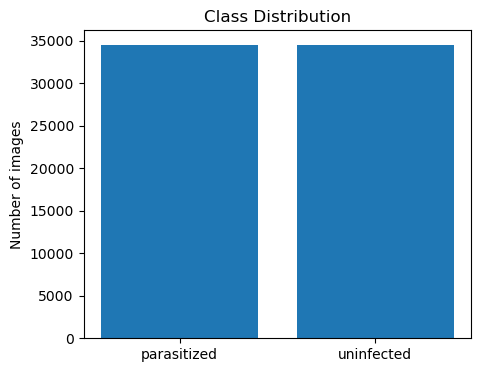

In [45]:
plt.figure(figsize=(5, 4))
plt.bar(counts.keys(), counts.values())
plt.title("Class Distribution")
plt.ylabel("Number of images")
plt.show()

### **Visualize Sample Images**

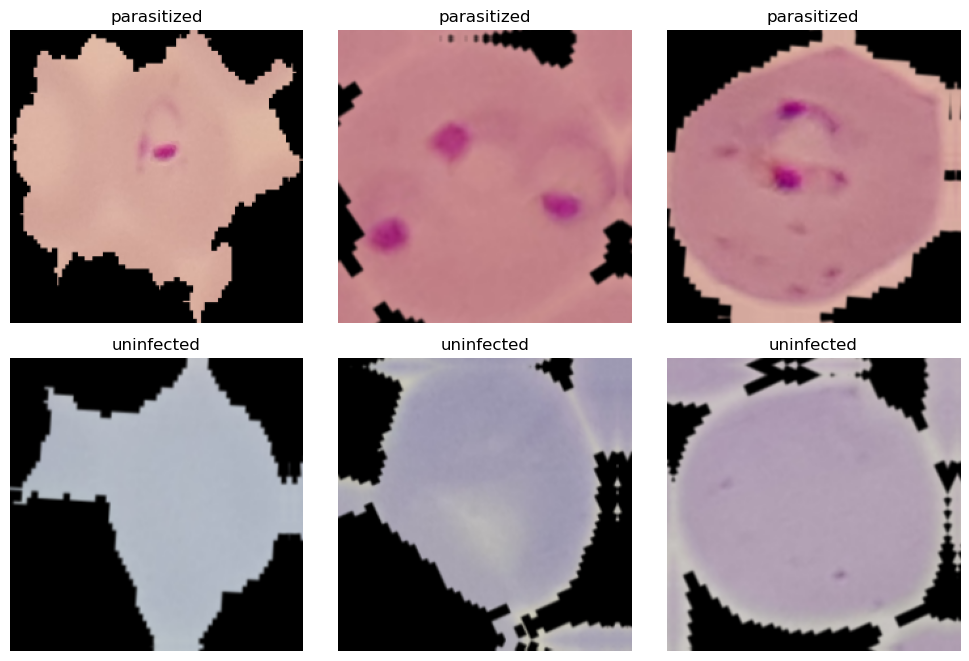

In [46]:
# ----- Visualize 9 random images (3 per class, max) -----
samples = []
for cls in class_names:
    cls_dir = os.path.join(DATA_DIR, cls)
    files = [
        f for f in os.listdir(cls_dir)
        if os.path.isfile(os.path.join(cls_dir, f))
    ]
    if not files:
        continue
    k = min(3, len(files))
    for f in random.sample(files, k):
        samples.append((os.path.join(cls_dir, f), cls))

samples = samples[:9]

plt.figure(figsize=(10, 10))
for i, (path, cls) in enumerate(samples):
    img = Image.open(path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


### **Load Images from Local Directory**

In [47]:
import tensorflow as tf

IMG_SIZE = 128
BATCH_SIZE = 16   # keep this small to avoid crashes
SEED = 42

full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 69000 files belonging to 2 classes.


### **Extract Class Names**

In [48]:
class_names = full_ds.class_names
print("TF class names:", class_names)

TF class names: ['parasitized', 'uninfected']


### **Determine Dataset Size**

In [49]:
total_batches = tf.data.experimental.cardinality(full_ds).numpy()
print("Total batches:", total_batches)

Total batches: 4313


### **Split Dataset Into Train/Validation/Test**

In [50]:
train_batches = int(0.7 * total_batches)
val_batches   = int(0.15 * total_batches)
test_batches  = total_batches - train_batches - val_batches

train_ds = full_ds.take(train_batches)
val_ds   = full_ds.skip(train_batches).take(val_batches)
test_ds  = full_ds.skip(train_batches + val_batches)

print("Train batches:", train_batches)
print("Val batches:", val_batches)
print("Test batches:", test_batches)

Train batches: 3019
Val batches: 646
Test batches: 648


### **Enable AUTOTUNE**

In [51]:
AUTOTUNE = tf.data.AUTOTUNE

### **Preprocessing Function**

In [52]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # [0,1]
    return image, label

### **Build Final TensorFlow Datasets**

In [53]:
train_ds_prepared = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

val_ds_prepared = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

test_ds_prepared = (
    test_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

### **Build the Convolutional Neural Network (CNN)**

In [54]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(len(class_names), activation="softmax"),
    ])
    return model

### **Instantiate and Summarize the Model**

In [55]:
model = build_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Compile the CNN**

In [56]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### **Define Training Callbacks**

In [57]:
checkpoint_path = "malaria_cnn_best.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
]

### **Train the Model**

In [58]:
history = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=20,
    callbacks=callbacks,
)

Epoch 1/20
3019/3019 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8663 - loss: 0.3238
Epoch 1: val_accuracy improved from -inf to 0.95588, saving model to malaria_cnn_best.keras
3019/3019 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.8663 - loss: 0.3237 - val_accuracy: 0.9559 - val_loss: 0.1489
Epoch 2/20
3017/3019 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9563 - loss: 0.1435
Epoch 2: val_accuracy did not improve from 0.95588
3019/3019 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.9563 - loss: 0.1435 - val_accuracy: 0.9532 - val_loss: 0.1455
Epoch 3/20
3015/3019 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9583 - loss: 0.1266
Epoch 3: val_accuracy improved from 0.95588 to 0.95946, saving model to malaria_cnn_best.keras
3019/3019 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9583 - loss: 0.1266 - val_accuracy: 0.9595 - val_loss: 0.1357
Epoch 4/20
3017/3019 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9611 - loss: 0.1199
Epoch 4: val_accuracy did not improve from 0.

### **Extract Training History**

In [59]:
history_dict = history.history

### **Plot Curves**

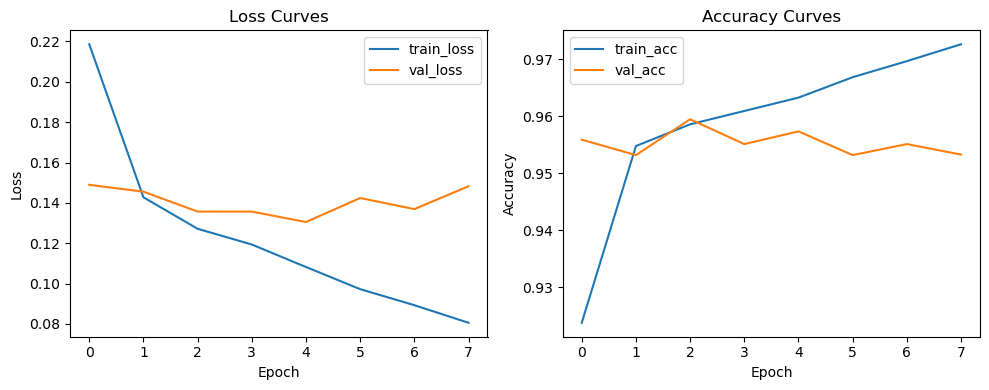

In [60]:
plt.figure(figsize=(10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="train_loss")
plt.plot(history_dict["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves") 

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict["accuracy"], label="train_acc")
plt.plot(history_dict["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves") 

plt.tight_layout()
plt.show()

### **Compute Test Loss and Accuracy**

In [61]:
test_loss, test_acc = model.evaluate(test_ds_prepared)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9603 - loss: 0.1328
Test Loss: 0.1315
Test Accuracy: 0.9604


### **Generate Predictions for Test Samples**

In [62]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds_prepared:
    preds = model.predict(images, verbose=0)
    preds_labels = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

2025-11-22 03:16:14.867487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### **Classification Report**

In [63]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

 parasitized       0.97      0.95      0.96      5264
  uninfected       0.95      0.97      0.96      5096

    accuracy                           0.96     10360
   macro avg       0.96      0.96      0.96     10360
weighted avg       0.96      0.96      0.96     10360



### **Confusion Matrix**

In [64]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[4996  268]
 [ 142 4954]]


### **Save Model**

In [65]:
model.save("malaria_cnn_final.keras")
print("Model saved as 'malaria_cnn_final.keras'")


Model saved as 'malaria_cnn_final.keras'


### **Prediction Script**

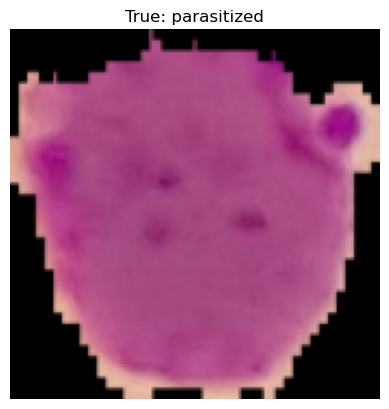

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted: parasitized
True: parasitized


In [66]:
# Take one batch from test dataset
for images, labels in test_ds_prepared.take(1):
    sample_images = images
    sample_labels = labels
    break

idx = 0  # pick any index in [0, BATCH_SIZE)
img = sample_images[idx]
true_label = int(sample_labels[idx].numpy())

plt.imshow(img.numpy())
plt.axis("off")
plt.title(f"True: {class_names[true_label]}")
plt.show()

img_batch = tf.expand_dims(img, axis=0)
pred_probs = model.predict(img_batch)
pred_label = int(np.argmax(pred_probs, axis=1)[0])

print("Predicted:", class_names[pred_label])
print("True:", class_names[true_label])
